# Comparing Systematic Investment Strategies

In this investigation, we will compare dollar-cost averaging (DCA) against other similar long-term investment strategies.

## Comparison 1
First, we will see if backwardation is a good buy signal. The control will be the performance of DCA given the same capital (a biweekly paycheck) and timeframe. The backwardation investment strategy will only buy if cash > 0 and the asset is in backwardation. The DCA investment strategy will always buy as soon as cash > 0. The strategy that accumulates the higher quantity of the asset should be the better strategy.
In this experiment, I used Bitcoin spot and perpetual futures prices. I pulled prices from the Bitfinex API. The strategies' goal is to accumulate the most amount of bitcoins.

In [3]:
# Saving data
import requests
import json
from datetime import datetime

earliest = 1562112000000  # When futures started
day_to_ms = 86400 * 1000
latest = int(datetime.utcnow().timestamp() * 1000) - day_to_ms


def get_ohlc(timeframe, symbol, limit, start, end, old_first=True):
    sort = 1 if old_first else -1
    url = f"https://api-pub.bitfinex.com/v2/candles/trade:{timeframe}:{symbol}/" \
          f"hist?limit={limit}&start={start}&end={end}&sort={sort}"
    headers = {"accept": "application/json"}
    response = requests.get(url, headers=headers)
    return response.json()


def save_data():  # Download spot and perps data going back to earliest perps date
    spot = get_ohlc(timeframe="1D", symbol="tBTCUSD", limit=10000, start=earliest, end=latest)
    perps = get_ohlc(timeframe="1D", symbol="tBTCF0:USTF0", limit=10000, start=earliest, end=latest)
    json.dump(spot, open("spot.json", "w"))
    json.dump(perps, open("perps.json", "w"))

In [ ]:
save_data()

,spot,perps,back,income,cash,backstrat,dcastrat
1672185600000,16558.0,16554.0,True,0,0,2.581498,2.578506
1672272000000,16658.0,16656.0,True,0,0,2.581498,2.578506
1672358400000,16618.0,16616.0,True,0,0,2.581498,2.578506
1672444800000,16564.0,16554.0,True,0,0,2.581498,2.578506
1672531200000,16629.0,16615.0,True,500,0,2.611566,2.608574


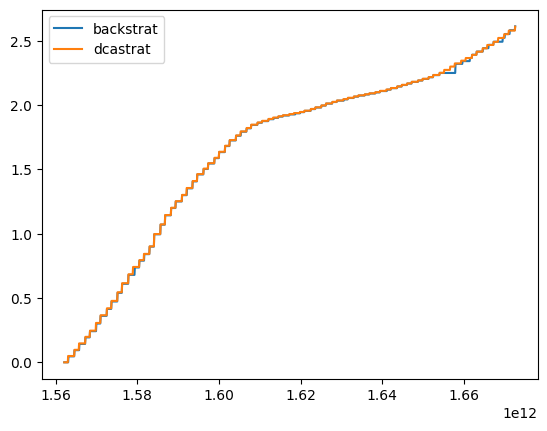

In [4]:
# Backtesting and analysis
import pandas as pd
import matplotlib.pyplot as mp

earliest = 1562112000000
day_to_ms = 86400 * 1000
latest = int(datetime.utcnow().timestamp() * 1000) - day_to_ms
paycheck = 500


def get_close_prices(filename):
    time_close_dict = dict()
    for candle_json in json.load(open(filename, "r")):
        candle = candle_json[0], candle_json[2]
        time_close_dict[candle[0]] = candle[1]
    return time_close_dict


s1 = pd.Series(get_close_prices("spot.json"), name="spot")
s2 = pd.Series(get_close_prices("perps.json"), name="perps")
df = pd.concat([s1, s2], axis=1)
df.fillna(method='ffill', inplace=True)  # Some timestamps don't have a perp price. Give it prev perp price

df["back"] = df.apply(lambda row: row["spot"] > row["perps"], axis=1)
df["income"] = df.apply(lambda row: paycheck if datetime.utcfromtimestamp(row.name / 1000).day in [1, 14] else 0, axis=1)
df["cash"] = 0
df["backstrat"] = 0
df["dcastrat"] = 0
df.loc[earliest, "cash"] = df.loc[earliest, "income"]
for i in range(earliest, latest, day_to_ms):
    if i != earliest:
        df.loc[i, "cash"] = df.loc[i - day_to_ms, "cash"] + df.loc[i, "income"]
        df.loc[i, "backstrat"] = df.loc[i - day_to_ms, "backstrat"]
        df.loc[i, "dcastrat"] = df.loc[i - day_to_ms, "dcastrat"]
    if df.loc[i, "cash"] > 0 and df.loc[i, "back"]:  # If we have cash and in backwardation
        df.loc[i, "backstrat"] += df.loc[i, "cash"] / df.loc[i, "spot"]
        df.loc[i, "cash"] = 0
    if df.loc[i, "income"] == paycheck:
        df.loc[i, "dcastrat"] += paycheck / df.loc[i, "spot"]

display(df.tail())
df.plot(y=["backstrat", "dcastrat"], kind="line")
mp.show()

From the tail of the dataframe, we can see that the backwardation strategy accumulated more bitcoins than the DCA strategy. However, when we look at the graph, we can see that at no point did the backwardation strategy have a significant advantage over the DCA strategy. I conclude that the backwardation strategy is not superior to dollar-cost averaging.

## Comparison 2

Next, we will compare the performances of a daily dollar-cost average strategy and a strategy that only invests on red days ("buy the dip"). A red day is a trading day where the close is less than the close of the previous trading day. We will see which strategy has the greatest overall average return.
In this experiment, I used daily adjusted close prices of the SPY ETF from December 2014 to December 2022. I downloaded the historical daily data from Yahoo Finance.

DCA Performance: 47.23%
Modified DCA Performance: 48.08%


,Adj Close,DCA,Strat
0,179.338211,179.338211,179.338211
1,177.558624,177.558624,177.558624
2,177.463654,177.463654,177.463654
3,174.258652,174.258652,174.258652
4,172.617325,172.617325,172.617325
...,...,...,...
2009,386.230011,386.230011,NaN
2010,380.720001,380.720001,380.720001
2011,382.910004,382.910004,NaN
2012,381.399994,381.399994,381.399994


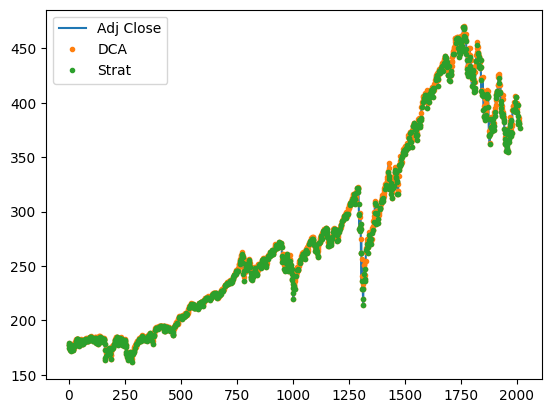

In [5]:
def calc_perf(current, prices):  # Calculate performance given current price and buy prices
    running_sum = 0
    count = 0
    for price in prices:
        if pd.isna(price):
            continue
        if price != 0:
            running_sum += (current - price) / price
        count += 1
    return running_sum / count


spy = pd.read_csv('SPY.csv')
adj_close = spy["Adj Close"]
dca_series = pd.Series(adj_close[1:], name="DCA")
strat_series = pd.Series([0], name="Strat")
for i in range(1, adj_close.count()):
    if adj_close[i - 1] > adj_close[i]:
        strat_series[i] = adj_close[i]
dca_series.shift(1)
strat_series.shift(1)
df = pd.concat([adj_close, dca_series, strat_series], axis=1)[1:]
df.reset_index(drop=True, inplace=True)

last_price = adj_close[len(adj_close) - 1]
print(f"DCA Performance: {round(calc_perf(last_price, list(dca_series)) * 100, 2)}%")
print(f"Modified DCA Performance: {round(calc_perf(last_price, list(strat_series)) * 100, 2)}%")

df["Adj Close"].plot(kind="line", legend=True)
df["DCA"].plot(style='.', legend=True)
df["Strat"].plot(style='.', legend=True)
display(df)
mp.show()

Strategy Correlation: 0.9999392301882255


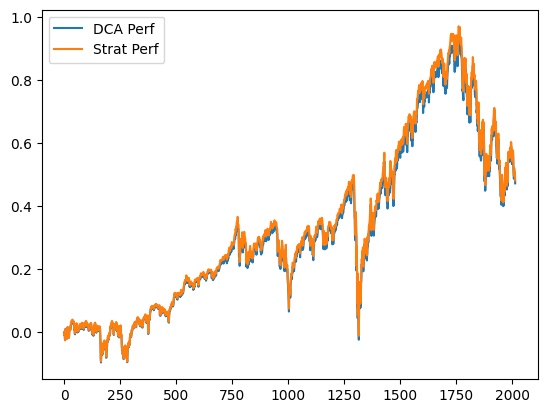

In [9]:
# Calculating average performance over time
df["DCA Perf"] = 0
df["Strat Perf"] = 0
for i in range(1, len(df.index)):
    curr_price = df.loc[i, "Adj Close"]
    df.loc[i, "DCA Perf"] = calc_perf(curr_price, list(df["DCA"])[:i])
    df.loc[i, "Strat Perf"] = calc_perf(curr_price, list(df["Strat"])[:i])
print(f'Strategy Correlation: {df["DCA Perf"].corr(df["Strat Perf"])}')
df["DCA Perf"].plot(kind="line", legend=True)
df["Strat Perf"].plot(kind="line", legend=True)
mp.show()

Over eight years, we can see that the average performance of the "buy the dip" strategy barely outperformed the average performance of the normal DCA. The margin of improvement is not enough to conclude that the "buy the dip" strategy is superior. Additionally, the correlation between the two strategies is quite strong, so we can determine that there is no advantage to buying the dip. Even if the "buy the dip" strategy was advantageous, it would not be practical as it would be hard to know how much capital to deploy as future buying opportunities are unknown.

## Conclusion

The dollar-cost average strategy continues to be a solid long-term investment strategy. There is no need to do anything fancy.